# us open

the us open is this weekend, and I wanted to play around with a few machine learning models to see if I could predict:

* who wil make the cut
* who will finish where

these two questions can be answered with machine learning classificaiton and regression problems. to predict who will make the cut, we will have a training data set that contains player name, season several strokes gained variables and whether they made they cut or not. this training data set contains data from only US opens in 2019, 2021 and 2022. 

the testing data set will then contain player name, season and the same strokes gained variables from tournaments thus far (through RBC heritage canadian open) in 2023. I believe to score the model we need to have data on who actually makes the cut in the 2023 US open... so I am not sure if we can fully answer this question yet.

to predict who will finish where, we can run a regression model that uses the strokes gained variables and year to predict finish from those previous three US opens. we can train a model on the same data, except the "target" variable is no longer binary (0/1). the testing data set will be the same as above, and we should be able to use the `predict()` function to predict finsh in this year's US open, based on average strokes gained this season

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 
# we want plots to appear in line in the notebook

# models from sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# model evals

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, RocCurveDisplay


## the data

I played around with this same data in R, so I have created all the training and testing files already. the training data (US open strokes gained from 2019, 2021, 2022) comes from <https://www.kaggle.com/datasets/robikscube/pga-tour-golf-data-20152022>, and the testing data (2023 strokes gained through the RBC Candadian Open -- tournament directly preceeding US open) comes from <https://www.pgatour.com/stats/strokes-gained>.

**a big caveat is that I do not have LIV strokes gained data for 2023** I suppose I could have attempted to locate it but as of now I do not, and thus the LIV players are not included in these data analyses

### classification problem: who makes the cut?

In [12]:
train_class = pd.read_csv("usopen_classification_train.csv")

In [13]:
train_class.head()

,player id,season,sg_putt,sg_arg,sg_app,sg_ott,finish_class
0,5548,2022,1.30,0.80,0.54,0.21,1
1,3832,2022,-1.42,0.73,0.87,-0.81,0
2,5502,2022,1.43,0.60,-0.48,-0.45,1
3,10372,2022,0.66,0.65,0.14,0.14,1
4,388,2022,0.54,0.79,1.20,-0.43,1


In [14]:
train_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player id     478 non-null    int64  
 1   season        478 non-null    int64  
 2   sg_putt       478 non-null    float64
 3   sg_arg        478 non-null    float64
 4   sg_app        478 non-null    float64
 5   sg_ott        478 non-null    float64
 6   finish_class  478 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 26.3 KB


the below plot shows how many made and missed the cut in the previous opens in our data set

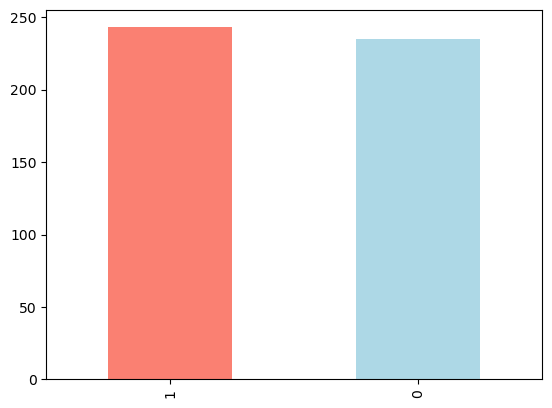

In [15]:
train_class.finish_class.value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

the following plot shows strokes gained off the tee (x axis) by strokes gained putting (y axis) for those who made (red) and missed (blue) the cut. the plot is showing a somewhat linear relationship between the 2 variables -- and slightly higher strokes gained in both areas for those who made the cut vs missed. however, the data seem relatively simily, which makes me wonder if it will be hard to predict who is finishing where. perhaps due to something like the US open being a highly competitive field where players are all playing at a high clip... and might be hard to build a model with a high prediction accuracy! 

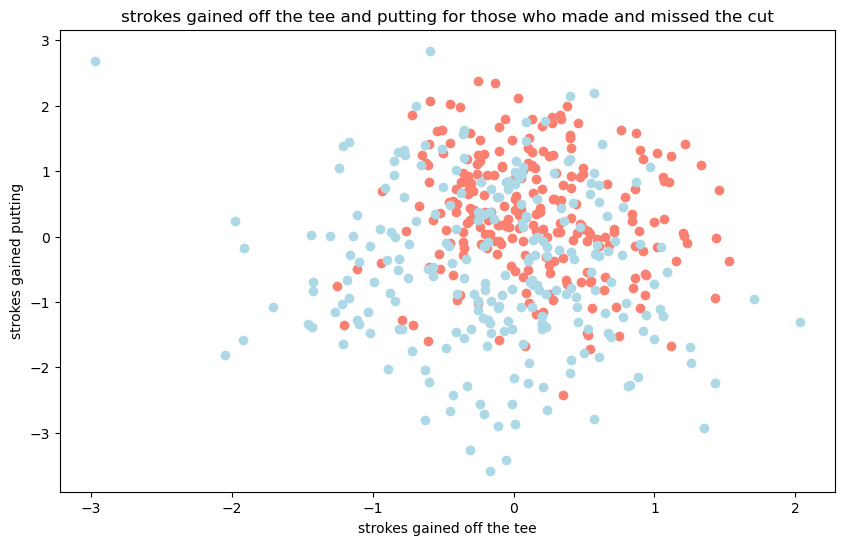

In [21]:
plt.figure(figsize=(10,6))

# scatter

plt.scatter(train_class.sg_ott[train_class.finish_class==1],
           train_class.sg_putt[train_class.finish_class==1],
           color="salmon")

# scatter with negative examples

plt.scatter(train_class.sg_ott[train_class.finish_class==0],
           train_class.sg_putt[train_class.finish_class==0],
           c="lightblue")

plt.title("strokes gained off the tee and putting for those who made and missed the cut")

plt.xlabel("strokes gained off the tee")
plt.ylabel("strokes gained putting")
plt.xticks(rotation=0);

#### begin building a model that predicts who will make or miss the cut just based on the training data

we are going to only use the training data set (and split that into training and testing) for now to score and create a model that predicts with high accuracy. then, we will use the untouched testing data to make predictions based on that tuned model

In [16]:
# split data into x and y

x= train_class.drop("finish_class", axis=1)

y= train_class.finish_class

In [17]:
np.random.seed(22)

# split into training and testing data (again, here just using the old training data)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

#### logistic regression model

Logistic regression is a statistical method for predicting binary classes. The outcome or target variable is dichotomous in nature. Dichotomous means there are only two possible classes. For example, it can be used for cancer detection problems. It computes the probability of an event occurrence.

It is a special case of linear regression where the target variable is categorical in nature. It uses a log of odds as the dependent variable. Logistic Regression predicts the probability of occurrence of a binary event utilizing a logit function.

In [18]:
### logistic regression

np.random.seed(22)

logreg= LogisticRegression()

logreg.fit(x_train,y_train)
logreg.score(x_test,y_test) ### not very good


0.5833333333333334

our model was scored with an R2 of 58%... that is not a great score so we are going to try using another method

#### random forest classifier 

A random forest is a supervised machine learning estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. It consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model’s prediction

In [20]:
## random forest

np.random.seed(42)

RF= RandomForestClassifier()

RF.fit(x_train,y_train)
RF.score(x_test,y_test) ### better

0.8229166666666666

our R2 for the random forest model was up to around 83%, so we are going to use that method but tune the model a bit more specifically to our data

#### tune hyper parameters with `gridsearchCV()`

this function takes parameters associated with the model and searches across a grid of different inputs for those parameters to find which combinations made the model perform the best,

In [31]:
# different hyper parameterss for random forest

# these are just random input parameters I am trying here for this model. 
# tbh I am not 100% sure how to know what to try but this is what I learned

rf_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

gs_rf = GridSearchCV(estimator = RandomForestClassifier(), param_grid = rf_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# fit

In [117]:
gs_rf.fit(x_train,y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 150, 278]},
             verbose=2)

In [35]:
gs_rf.best_params_

{'bootstrap': True,
 'max_depth': 100,
 'max_features': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}

In [47]:
# create model based on those best parameters identified above

clf= RandomForestClassifier(bootstrap=True,
                           max_depth=100,
                           max_features=2,
                            min_samples_leaf=5,
                            min_samples_split=12,
                            n_estimators=100,
                           random_state=22)

now, still using just the training data, we can get several measures of model performance:
    
    * accuracy
    * precision
    * recall1
    * F1
    
we can do this using cross validation. cross validation will split the data into (here: 5) groups and run the model on all splits. that way, we get a range of scores/ model performances and not just 1 based on a random split. because of that, we can pass the model the `cross_val_score()` function all the data (x&y) because it will split it

In [48]:
### cross validated accuracy

cv_acc = cross_val_score(clf,
                         x,   ### can pass all x and y data bc using CV
                         y,
                         cv=5,
                         scoring="accuracy")

cv_acc.mean() ## accuracy over 80% for cross validated data

0.820219298245614

In [49]:
### cross validated precision

cv_prec = cross_val_score(clf,
                         x,   ### can pass all x and y data bc using CV
                         y,
                         cv=5,
                         scoring="precision")

cv_prec.mean() ## precision over 80%

0.8481287851631585

In [39]:
### cross validated recall

cv_recall = cross_val_score(clf,
                         x,   ### can pass all x and y data bc using CV
                         y,
                         cv=5,
                         scoring="recall")

cv_recall.mean() # recall close to 80%

0.7943877551020408

In [50]:
### cross validated F1 score

cv_f1 = cross_val_score(clf,
                         x,   ### can pass all x and y data bc using CV
                         y,
                         cv=5,
                         scoring="f1")

cv_f1.mean() ## F1 score over 80%

0.8202818124968877

now, we can fit the model to the training data and get predictions to really ensure our model is performing well

In [51]:
%%capture --no-display
clf.fit(x_train,y_train)

RandomForestClassifier(max_depth=100, max_features=2, min_samples_leaf=5,
                       min_samples_split=12, random_state=22)

In [52]:
clf.score(x_train,y_train) # nice job!! 

0.9162303664921466

our model, on only training data so far, is predicting who makes or misses the cut with an R2 of almost 92%. that indicates it is minimizing a lot of error and predicting well. 

In [62]:
# make predictions

y_preds= clf.predict(x_test) # best fitting model

accuracy_score(y_test, y_preds)

0.875

above we see our final model on the testing data has almost 88% accuracy. that's pretty good for this! the below plot is a confusion matrix and shows our correct and false predicitons based on the training data. the false predictions are in the black cells, meaning we only mis-predicted 12 total observations.

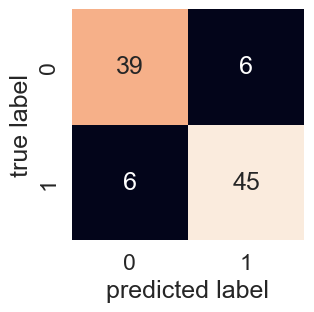

In [63]:
import seaborn as sns 

sns.set(font_scale=1.5)

def plot_conf_mat(y_test,y_preds):
    """
    Plots a nice looking confusion matrix using seaborn's heatmap()
    """
    fig, ax=plt.subplots(figsize=(3,3))
    ax= sns.heatmap(confusion_matrix(y_test,y_preds),
                   annot=True,
                   cbar=False)
    plt.xlabel("predicted label")
    plt.ylabel("true label")
    
plot_conf_mat(y_test,y_preds)

#### now, let's make predictions based on the 2023 strokes gained data

or the *real* testing data

In [57]:
test = pd.read_csv("usopen_test.csv")

In [58]:
test.head()

,player id,season,sg_putt,sg_arg,sg_app,sg_ott
0,16,2023,0.351,0.534,0.025,-0.423
1,10577,2023,0.559,0.228,-0.795,-0.170
2,5548,2023,0.356,0.103,0.350,0.048
3,6015,2023,0.406,0.094,-0.539,-0.285
4,10372,2023,0.355,0.106,0.099,0.024


In [64]:
# call our same model (the best tuned random forest model)

us_open_preds= clf.predict(test)

In [65]:
# what our predictions look like -- series of 0s and 1s

us_open_preds

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1])

now, we cannot score our model for real because the US open has not happened. so we have no idea how the model is really performing, but we do have predictions we can be on the lookout for!

In [67]:
test["preds"]= us_open_preds

In [68]:
test.head()

,player id,season,sg_putt,sg_arg,sg_app,sg_ott,preds
0,16,2023,0.351,0.534,0.025,-0.423,1
1,10577,2023,0.559,0.228,-0.795,-0.170,0
2,5548,2023,0.356,0.103,0.350,0.048,1
3,6015,2023,0.406,0.094,-0.539,-0.285,1
4,10372,2023,0.355,0.106,0.099,0.024,1


In [69]:
# match with player names to see who we will predict will make the cut

ids= pd.read_csv("us_open_ids.csv")

In [70]:
ids.head()

,player,player id
0,Adam Hadwin,5548
1,Alexander Noren,3832
2,Andrew Putnam,5502
3,Adam Schenk,10372
4,Adam Scott,388


the merged data set below shows who we predict will and won't make the cut. e.g. aaron wise (not even sure if he is playing!) and webb simpson will not make the cut.but adam hadwin, xander and zach johnson are predicted *to* make the cut

In [71]:
df = pd.merge(test, ids, on="player id")
df

,player id,season,sg_putt,sg_arg,sg_app,sg_ott,preds,player
0,16,2023,0.351,0.534,0.025,-0.423,1,Aaron Baddeley
1,10577,2023,0.559,0.228,-0.795,-0.170,0,Aaron Wise
2,5548,2023,0.356,0.103,0.350,0.048,1,Adam Hadwin
3,6015,2023,0.406,0.094,-0.539,-0.285,1,Adam Long
4,10372,2023,0.355,0.106,0.099,0.024,1,Adam Schenk
...,...,...,...,...,...,...,...,...
116,1614,2023,-0.162,-0.207,0.193,-0.405,0,Webb Simpson
117,11119,2023,0.292,0.147,0.548,0.231,1,Wyndham Clark
118,10140,2023,0.577,0.148,0.888,0.338,1,Xander Schauffele
119,9040,2023,-0.092,0.319,-0.102,-0.394,1,Zac Blair


In [96]:
df.shape

(121, 8)

In [97]:
test.shape # makeing sure we made predictions on all 121 people

(121, 7)

In [73]:
cut_preds = df.filter(['player', 'preds'], axis=1)

In [76]:
cut_preds
!pwd
cut_preds.to_csv('sklearn_cut_predictions.csv') 

/Users/claire/Desktop/usopen


## linear regression: who finishes where?

In [77]:
train= pd.read_csv("usopen_regression_train.csv")

In [78]:
train.head()

,player id,season,sg_putt,sg_arg,sg_app,sg_ott,finish2
0,5548,2022,1.30,0.80,0.54,0.21,7
1,3832,2022,-1.42,0.73,0.87,-0.81,78
2,5502,2022,1.43,0.60,-0.48,-0.45,31
3,10372,2022,0.66,0.65,0.14,0.14,24
4,388,2022,0.54,0.79,1.20,-0.43,14


#### random forest regressor 
here we are going to try random forest regressor. this model is similar to random forest classifier (using decision trees) but now we are predicting linear values, not just binary

In [86]:
# call model

from sklearn.ensemble import RandomForestRegressor

model= RandomForestRegressor(n_jobs=-1,
                            random_state=22)


# fit

model.fit(train.drop("finish2", axis=1), train.finish2)

RandomForestRegressor(n_jobs=-1, random_state=22)

In [87]:
model.score(train.drop("finish2", axis=1), train.finish2)

0.9705625898908892

our model predicts finish based on only on the training data with an R2 of 97%! that's pretty high

In [88]:
# split training data into x and y

x_train, y_train= train.drop("finish2", axis=1), train.finish2

In [89]:
x_train.shape, y_train.shape

((478, 6), (478,))

#### search for best hyper parameters with `GridSearchCV()`

In [94]:
rf_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100,150,278]
}

gs_rf = GridSearchCV(estimator = RandomForestRegressor(), param_grid = rf_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# fit

In [95]:
%%capture --no-display
gs_rf.fit(x_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 150, 278]},
             verbose=2)

In [96]:
gs_rf.score(x_train,y_train) ## 92%! pretty good R2

0.9191868008359544

In [97]:
gs_rf.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 278}

#### now we can create a model with the best parameters from `gridsearchCV()`

In [98]:
rf_model = RandomForestRegressor(n_estimators=278,
                                   min_samples_leaf=3,
                                   min_samples_split=8,
                                   max_features=3,
                                   max_depth=90,
                                   n_jobs=-1,
                                   random_state=22,
                                   bootstrap=True)

In [99]:
rf_model.fit(x_train,y_train)

RandomForestRegressor(max_depth=90, max_features=3, min_samples_leaf=3,
                      min_samples_split=8, n_estimators=278, n_jobs=-1,
                      random_state=22)

In [100]:
rf_model.score(x_train,y_train) # 91% same score, just confirming it

0.919241024018051

#### now, we can make predictions on the testing data

or the 2023 strokes gained data

In [107]:
test = pd.read_csv("usopen_test.csv")

In [108]:
test.head()

,player id,season,sg_putt,sg_arg,sg_app,sg_ott
0,16,2023,0.351,0.534,0.025,-0.423
1,10577,2023,0.559,0.228,-0.795,-0.170
2,5548,2023,0.356,0.103,0.350,0.048
3,6015,2023,0.406,0.094,-0.539,-0.285
4,10372,2023,0.355,0.106,0.099,0.024


In [109]:
test_preds = rf_model.predict(test)

In [110]:
finish_preds = pd.DataFrame()
finish_preds["player id"] =  test["player id"]
finish_preds["finish_preds"] = test_preds

finish_preds

,player id,finish_preds
0,16,48.984451
1,10577,71.396824
2,5548,35.490957
3,6015,61.675382
4,10372,45.304341
...,...,...
116,1614,63.330153
117,11119,28.767282
118,10140,20.333264
119,9040,62.136972


In [115]:
df = pd.merge(finish_preds, ids, on="player id")
df.to_csv("sklearn_linear_preds.csv")

In [116]:
df.sort_values(by=['finish_preds'], ascending=True)[0:25]

,player id,finish_preds,player
51,9780,14.871281,Jon Rahm
98,9478,18.974344,Scottie Scheffler
114,5553,20.320680,Tyrrell Hatton
118,10140,20.333264,Xander Schauffele
111,2230,21.151423,Tony Finau
76,8973,22.598949,Max Homa
89,3470,23.055262,Rory McIlroy
110,5539,23.629236,Tommy Fleetwood
46,1680,23.837394,Jason Day
82,6007,25.254995,Patrick Cantlay


this model is predicting John Rahm to finish lowest in the US open, followed by scottie, tyrell hatton and xander. granted the lowest finish is only 14, but we can still try to track and see how the model does!